In [1]:

import csv
import os
import timeit

import argparse
import h5py
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ufl

from dolfinx import cpp, fem, io, mesh
from mpi4py import MPI
from petsc4py import PETSc
from scipy import interpolate

import commons, configs, constants

markers = commons.SurfaceMarkers()

In [2]:
Lz = 1
areas = {
    1: 100,
    6: 98.41,
    11: 36.38,
    16: 6.30,
    22: 0.45,
}
data_dir = f"mesh/study_2/test6/470-470-{Lz}_000-000-000/"

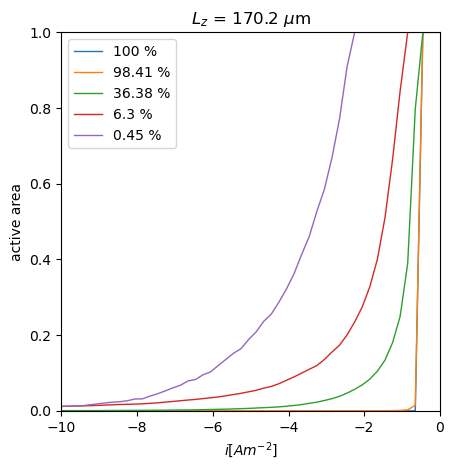

In [22]:
limits = {
    1: [-59, -58.5],
    5: [-15, -11],
    50: [-15, 0],
    100: [-10, 0],
}
Lz = 100
fig, ax = plt.subplots()
for img_id in [1, 6, 11, 16, 22]:
    data_path = os.path.join(f"mesh/study_2/test{img_id}/470-470-{Lz}_000-000-000/", "cdf.csv")
    df = pd.read_csv(data_path)
    ax.plot(df['i [A/m2]'], df['p_left'], label=f'{areas[img_id]} %', linewidth=1)

ax.set_xlabel('$i [Am^{-2}]$', fontdict={'fontsize': 'xx-large'})
ax.set_ylabel('active area', fontdict={'fontsize': 'xx-large'})
ax.set_title(f'$L_z$ = {800/470 * Lz:.1f} $\mu$m')
ax.set_box_aspect(1)
ax.set_ylim([0, 1])
ax.set_xlim(limits[Lz])
ax.legend()
plt.tight_layout()
plt.savefig(f'figures/study_2_cdf_{Lz}.png', dpi=1200)

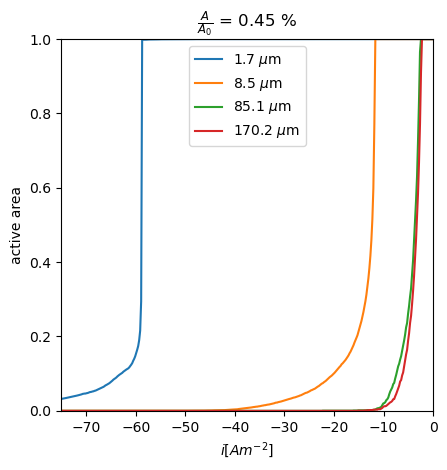

In [27]:
ul = 0
ll = -75
img_id = 22

fig, ax = plt.subplots()
for Lz in [1, 5, 50, 100]:
    data_path = os.path.join(f"mesh/study_2/test{img_id}/470-470-{Lz}_000-000-000/", "cdf.csv")
    df = pd.read_csv(data_path)
    ax.plot(df['i [A/m2]'], df['p_left'], label=f'{800/470*Lz:.1f} $\mu$m')

ax.set_xlabel('$i [Am^{-2}]$', fontdict={'fontsize': 'xx-large'})
ax.set_ylabel('active area', fontdict={'fontsize': 'xx-large'})
ax.set_title(r"$\frac{A}{A_0}$ = " + f"{areas[img_id]} %")
ax.set_box_aspect(1)
ax.set_ylim([0, 1])
ax.set_xlim([ll, ul])
ax.legend()
plt.tight_layout()
plt.savefig(f'figures/study_2_cdf-id{img_id}.png', dpi=1200)

In [ ]:
fig, ax = plt.subplots()
img = plt.imread('/home/molel/OneDrive/PhD/Data/Current_constriction/test6.tif')
ax.imshow(img[:, :, 0])
ax.set_box_aspect(1)
plt.tight_layout()
plt.savefig('figures/test6.png', dpi=1200)

In [3]:
A0 = 800e-6 ** 2  # m2
kappa = 0.1  # S/m

df = pd.read_excel('data/study_2_scaled.xlsx', sheet_name=['hi-res'])['hi-res']
df['area_fraction'] = np.around(df['area_fraction'], 4)
df['resistance [ohm]'] = (df['Lz [um]'] * 1e-6 / A0 * kappa) / df['effective_conductivity_ratio']
lengths = [1.702128, 8.5106, 85.1064, 170.2128]

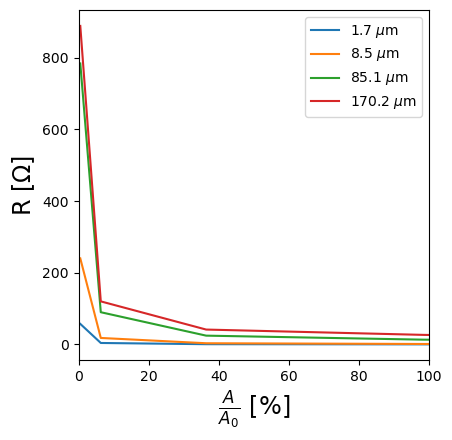

In [4]:
fig, ax = plt.subplots(figsize=(5, 4.5))
for lz in lengths:
    df_2 = df.loc[np.isclose(df['Lz [um]'], lz), :]
    ax.plot(100 * df_2['area_fraction'], df_2['resistance [ohm]'], label=f"{lz:.1f}" + " $\mu$m")
ax.set_box_aspect(1)
ax.set_xlim([0, 100])
# ax.set_ylim([0, 1])
ax.set_xlabel(r'$\frac{A}{A_0}$ [%]', fontdict={'fontsize': 'xx-large'})
ax.set_ylabel(r'R $[\Omega]$', fontdict={'fontsize': 'xx-large'})
ax.legend()
plt.tight_layout()
plt.savefig('figures/variable-area-comparison.png', dpi=1200)

In [6]:
area_fractions = [0.0045, 0.0630, 0.3638, 0.9841, 1.000]

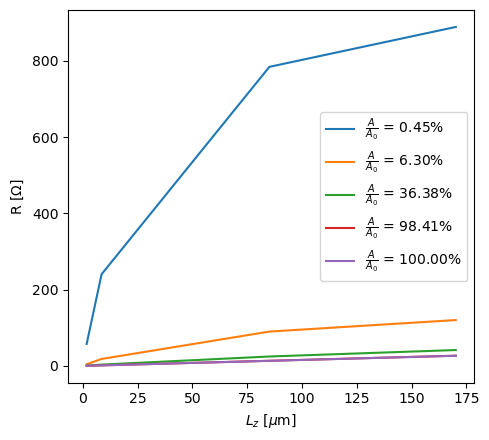

In [7]:
fig, ax = plt.subplots(figsize=(5, 4.5))
for af in area_fractions:
    df2 = df.loc[np.isclose(df['area_fraction'], af), :]
    ax.plot(df2['Lz [um]'], df2['resistance [ohm]'], label=r"$\frac{A}{A_0}$" + f" = {100 * af:.2f}%")
ax.legend()
ax.set_xlabel(f'$L_z$ [$\mu$m]', fontdict={'fontsize': 'xx-large'})
ax.set_ylabel(f'R [$\Omega$]', fontdict={'fontsize': 'xx-large'})
plt.tight_layout()
plt.savefig('figures/variable-length-comparison.png', dpi=1200)

In [17]:
df.head()

,area_fraction,effective_conductivity_ratio,Lz [um],error
0,0.004504,0.004637,1.702128,4.42%
1,0.063002,0.064434,1.702128,3.18%
2,0.363770,0.368950,1.702128,1.83%
3,0.984120,0.989720,1.702128,0.28%
4,1.000000,1.004300,1.702128,0.00%


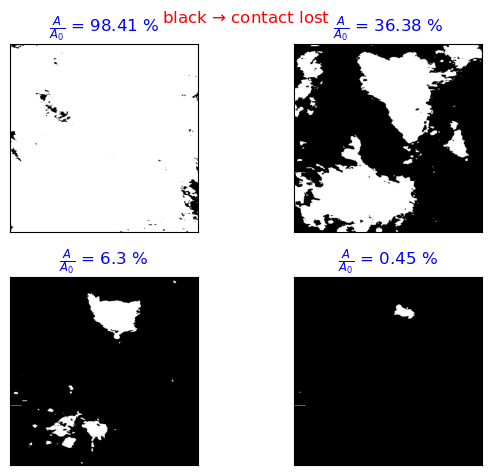

In [11]:
fig, ax = plt.subplots(2, 2)
for i, idx in enumerate([6, 11, 16, 22]):
    img = plt.imread(f'data/current_constriction/test{idx}.tif')[:, :, 0]
    ax[int(i/2), i % 2].imshow(img, cmap='gray')
    ax[int(i/2), i % 2].title.set_text(r"$\frac{A}{A_0}$ = " + f"{areas[idx]} %")
    ax[int(i/2), i % 2].title.set_color('blue')
    ax[int(i/2), i % 2].set_xticks([])
    ax[int(i/2), i % 2].set_yticks([])
plt.tight_layout()
fig.suptitle("black " + r"$\to$" + " contact lost", color='red')
plt.savefig('figures/contact-area-maps.png', dpi=1200)